In [64]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from tabulate import tabulate
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys

In [75]:
def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix
    # IMPLEMENT THIS METHOD
    k = (np.unique(y)).size
    d = np.shape(X)[1]
    mean = np.empty((d, k))
    covmat = np.empty((d,d))
    for i in range (1, k + 1):
        classIndex = np.where(y==i)[0]
        classData = X[classIndex,:]
        mean[:, i-1] = np.mean(classData, axis=0).transpose()
    covmat = np.cov(X.T)

    return mean,covmat

def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes

    # IMPLEMENT THIS METHOD
    k = (np.unique(y)).size
    d = np.shape(X)[1]
    mean = np.empty((d, k))
    covmats = []
    for i in range (1, k+1):
        classIndex = np.where(y==i)[0]
        classData = X[classIndex,:]
        mean[:, i-1] = np.mean(classData, axis=0).transpose()
        covmats.append(np.cov(np.transpose(classData)))

    return mean,covmats

def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    N = np.shape(Xtest)[0]
    classCount = np.shape(means)[1]
    ypred = np.empty((N, 1))
    incorrect = 0.0
    invCov = np.linalg.inv(covmat)
    #print invCov
    ytest = ytest.astype(int)
    for i in range (1, N + 1):
        pdf = 0
        predict_class = 0
        testX = np.transpose(Xtest[i-1,:])
        for j in range (1, classCount+1):
            result_pdf = np.exp((-1/2)*np.dot(np.dot(np.transpose(testX - means[:, j-1]),invCov),(testX - means[:, j-1])))
            if (result_pdf > pdf):
                predict_class = j
                ypred[i-1,:] = j;
                pdf = result_pdf
        if (predict_class != ytest[i-1]):
            incorrect = incorrect + 1
    accuracy = (N - incorrect)/N
    return accuracy*100,ypred

def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    classCount = np.shape(means)[1]
    d = np.shape(Xtest)[1]
    N = np.shape(Xtest)[0]

    temp = np.empty((N,classCount))
    predict_class = np.empty((N,1))

    incorrect = 0.0
    covmat_array = np.array(covmats)
    for i in range(0,classCount):
        for j in range(0,N):
            p = np.dot(np.dot(Xtest[j,:]-np.transpose(means[:,i]),np.linalg.inv(covmat_array[i])),(Xtest[j,:]-np.transpose(means[:,i])))
            temp[j,i] = 1/(2*pi)*np.sqrt(np.linalg.det(covmat_array[i])) * np.exp(p)

    predict_class = (np.argmin(temp,axis=1)) + 1

    for i in range(0,N):
        if(ytest[i] != predict_class[i]):
            incorrect = incorrect + 1
    ypred = predict_class.reshape(Xtest.shape[0],1)
    accuracy = (N - incorrect)/N
    return accuracy*100,ypred

def learnOLERegression(X,y):
    # Inputs:
    # X = N x d
    # y = N x 1
    # Output:
    # w = d x 1

    # IMPLEMENT THIS METHOD
    #Source : https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html
    w = np.dot(np.linalg.pinv(X), y)
    return w

def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d
    # y = N x 1
    # lambd = ridge parameter (scalar)
    # Output:
    # w = d x 1

    # IMPLEMENT THIS METHOD
     # Formula for Ridge expression to find W is - Inv[(XT.X + Lambda.I)].XT.Y
    w = np.linalg.inv(np.dot(X.T, X) + (lambd * np.identity(X.shape[1])))
    w = np.dot(np.dot(w, X.T), y)
    #print(w)
    return w

def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse

    # IMPLEMENT THIS METHOD
    NewY = np.dot(Xtest, w)
    #print NewY
    error = (ytest - NewY) * (ytest - NewY)
    #print error
    mse = np.sum(error, axis = 0) / Xtest.shape[0]
    return mse

def regressionObjVal(w, X, y, lambd):

    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda

    # IMPLEMENT THIS METHOD
    w = w.reshape(65,1)
    e = np.dot(X,w)
    XtX = np.dot(X.T, X)

    #error = (Y - X.W).T(Y - X.W) + Lambda.W.T.W
    error = 0.5 * np.dot((e - y).T, (e - y)) + 0.5 * lambd * np.dot(w.T, w)

    #error_grad = X.T.X.W - X.T.Y + Lambda.W
    error_grad = np.dot(XtX, w) - np.dot(X.T, y) + lambd * w
    error_grad = error_grad.flatten()
    #print('Testing')
    #print(error)
    #print(error_grad)
    return error, error_grad

def mapNonLinear(x,p):
    # Inputs:
    # x - a single column vector (N x 1)
    # p - integer (>= 0)
    # Outputs:
    # Xp - (N x (p+1))

    # IMPLEMENT THIS METHOD
    N = x.shape[0]
    Xp = np.ones((N, p+1))
    for i in range(1, p+1):
        Xp[:, i] = np.power(x,i)
    return Xp

LDA Accuracy = 97.0
QDA Accuracy = 95.0


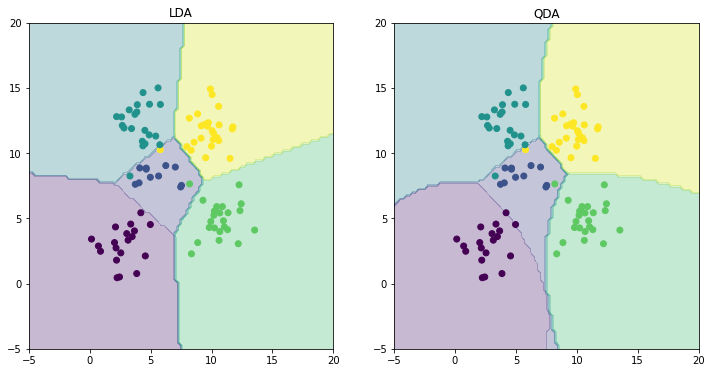

In [76]:
# Main script

# Problem 1
# load the sample data
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.flatten())
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.flatten())
plt.title('QDA')

plt.show()


In [77]:
# Problem 2
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))



MSE without intercept [106775.36145124]
MSE with intercept [3707.84018096]


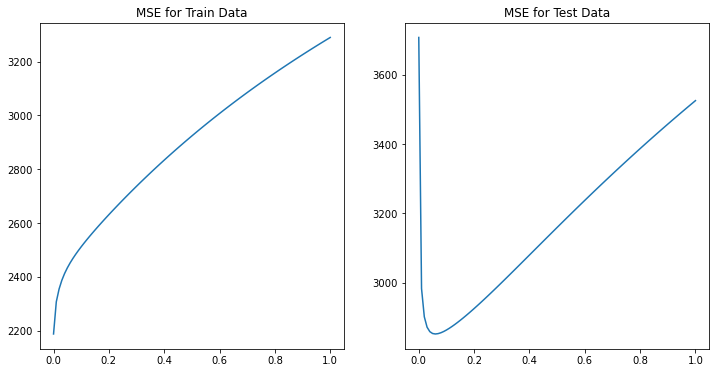

In [78]:
# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
#w=learnRidgeRegression(X_i,y,lambd)
#print(w)
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
#l1=lambdas

#l2=mses3_train
#l3=mses3
#l4=zip(l1,l2,l3)
#for i in l4:
    #print(i)


fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()


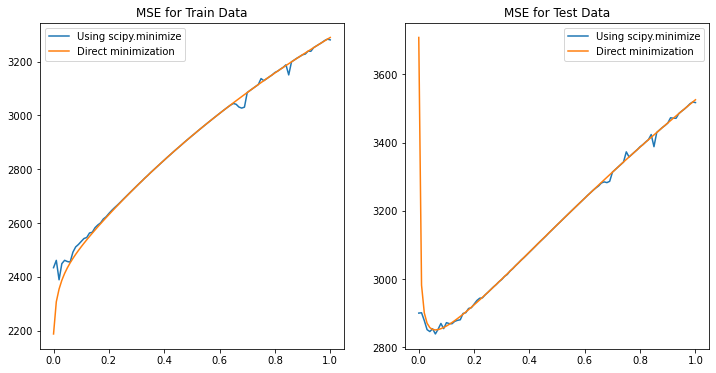

In [79]:
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()



[[5650.7105389  5650.71190703]
 [3930.91540732 3951.83912356]
 [3911.8396712  3950.68731238]
 [3911.18866493 3950.68253152]
 [3885.47306811 3950.6823368 ]
 [3885.4071574  3950.68233518]
 [3866.88344945 3950.68233514]]
[[6286.40479168 6286.88196694]
 [3845.03473017 3895.85646447]
 [3907.12809911 3895.58405594]
 [3887.97553824 3895.58271592]
 [4443.32789181 3895.58266828]
 [4554.83037743 3895.5826687 ]
 [6833.45914872 3895.58266872]]


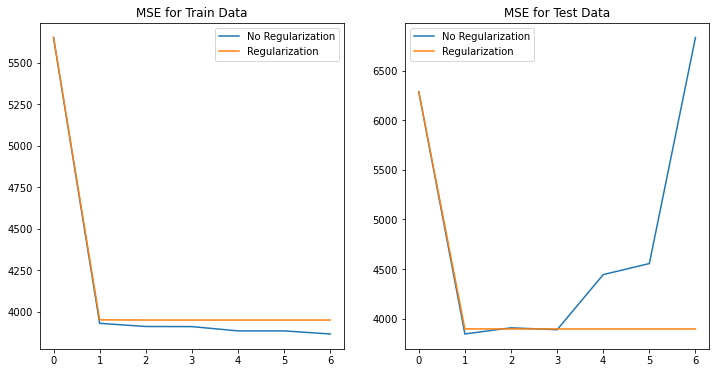

In [82]:
# Problem 5
pmax = 7
lambda_opt = 0.06 # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)

print(mses5_train)
print(mses5)
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()